# **IMAGE CAPTIONING ON MSCOCO DATASET**
**ANCHIT JHINGAN**

---

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
import os, zipfile
import sys
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import nltk
nltk.download('punkt')
from collections import Counter
import pickle
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import time

sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
os.chdir("/content/train2014")

### Initialize COCO API for instance annotations and caption anotations

In [6]:

dataDir = '/content/'
dataType = 'train2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)


captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=20.43s)
creating index...
index created!
loading annotations into memory...
Done (t=2.52s)
creating index...
index created!


### Dispalying a random image and its caption from mscoco dataset

http://images.cocodataset.org/train2014/COCO_train2014_000000283611.jpg


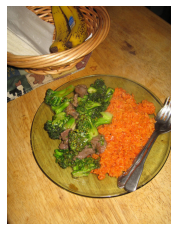

(640, 480, 3)
A plate with a fork has meat and broccoli on it.
A plate with someone's dinner that is on a table.
A plate of chicken and broccoli next to a half bowl of bananas.
A glass plate topped with carrots, broccoli and meat.
a table top with a plate of food on it 


In [7]:

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()
print(I.shape)

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

#### This code block is to initialize all global variables which will be required

In [16]:

batch_size = 64
vocab_path = '/content/drive/My Drive/project/Imcap/vocab.pkl'
encoder_path = '/content/drive/My Drive/project/Imcap/Checkpoint/encoder-5-6000.ckpt'
decoder_path = '/content/drive/My Drive/project/Imcap/Checkpoint/decoder-5-6000.ckpt'
train_imagepath = '/content/train2014/'
embed_dim = 256
hidden_dim = 512
num_layers = 1
epochs = 5
lr = 0.001
log_step = 100
    

### Create a Class to bulid vocabulary for captions


*   Accept captions as argument and add all these words in vocab. Dump this vocab object as a pickle file on drive. This file will contain all the words in our vocab

*   Add some special words like pad, unk, start, stop

*   Display total vocab size





In [9]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(coco, threshold):
  
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 10000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

vocab = build_vocab(coco_caps, threshold = 4)

with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)
  print("Total vocabulary size: {}".format(len(vocab)))
  

[10000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[30000/414113] Tokenized the captions.
[40000/414113] Tokenized the captions.
[50000/414113] Tokenized the captions.
[60000/414113] Tokenized the captions.
[70000/414113] Tokenized the captions.
[80000/414113] Tokenized the captions.
[90000/414113] Tokenized the captions.
[100000/414113] Tokenized the captions.
[110000/414113] Tokenized the captions.
[120000/414113] Tokenized the captions.
[130000/414113] Tokenized the captions.
[140000/414113] Tokenized the captions.
[150000/414113] Tokenized the captions.
[160000/414113] Tokenized the captions.
[170000/414113] Tokenized the captions.
[180000/414113] Tokenized the captions.
[190000/414113] Tokenized the captions.
[200000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[240000/414113] Tokenized the captions.
[250000/414113] Tokenized the captions.
[260000/4

### Using DataLoader to create a custom dataset by creating a class CocoDataset which extends data.Dataset

In [10]:
class CocoDataset(data.Dataset):
    def __init__(self, coco, vocab, transform=None):
        
        self.coco = coco
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(train_imagepath, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader( coco, vocab, transform, batch_size, shuffle, num_workers):
   
    coco = CocoDataset(
                       coco=coco,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn,
                                              drop_last=True)
    return data_loader

## Encoder



####   Transfer learning using pretrained resnet101 which is trained on Imagenet dataset. 
####   Image input is 224,224. Output is 2048,14,14

####  Extract feature vectors from input images.


In [11]:
#############################   ENCODER    ######################################################
# our image dim -> 256,256,3
# RESTNET101 => INPUT->3*224*224.     OUTPUT -> 2048, 14, 14
#Embed_size = encoded_image_size
# features  = out


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
       
        super(EncoderCNN, self).__init__()
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

## Decoder

####   Single Lstm Layer

#### Decode image feature vectors and generates captions.
#### Generate captions for given image features using greedy search

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
       
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
       
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## Training Code

#### 1.Transform images to required dimesions
#### 2. Get vocab directory
#### 3. Build dataset using data_loader function
#### 4. Initialize Encoder and Decoder class
#### 5. Define creterion, parameters and optimizer
#### 6. Training  loop


In [14]:


transform = transforms.Compose([ transforms.Resize(256),
                                    transforms.RandomCrop(224),
                                    transforms.RandomHorizontalFlip(), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.485, 0.456, 0.406), 
                                                        (0.229, 0.224, 0.225))])
                                
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)
    

  data_loader = get_loader(coco_caps, vocab, 
                             transform, batch_size,
                             shuffle=True, num_workers= 1) 

# Build the models
encoder = EncoderCNN(embed_dim).to(device)
decoder = DecoderRNN(embed_dim, hidden_dim, len(vocab),num_layers).to(device)
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=lr)
    
# Train the models
total_step = len(data_loader)
for epoch in range(epochs):
  start = time.time()
  for i, (images, captions, lengths) in enumerate(data_loader):
            
    # Set mini-batch dataset
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
    # Forward, backward and optimize
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()

    # Print log info
    if i % log_step == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(epoch, epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
      print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))      
    # Save the model checkpoints
    if (i+1) % 1000 == 0:
      torch.save(decoder.state_dict(), os.path.join('/content/drive/My Drive/project/Imcap/Checkpoint', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
      torch.save(encoder.state_dict(), os.path.join('/content/drive/My Drive/project/Imcap/Checkpoint', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))




Epoch [0/5], Step [0/6470], Loss: 9.2080, Perplexity: 9976.1307
Time taken for 1 epoch 1.1850621700286865 sec

Epoch [0/5], Step [100/6470], Loss: 3.9239, Perplexity: 50.5981
Time taken for 1 epoch 86.24069881439209 sec

Epoch [0/5], Step [200/6470], Loss: 3.4776, Perplexity: 32.3807
Time taken for 1 epoch 170.5328392982483 sec

Epoch [0/5], Step [300/6470], Loss: 3.3725, Perplexity: 29.1502
Time taken for 1 epoch 254.99041175842285 sec

Epoch [0/5], Step [400/6470], Loss: 3.0537, Perplexity: 21.1928
Time taken for 1 epoch 340.2065541744232 sec

Epoch [0/5], Step [500/6470], Loss: 2.9878, Perplexity: 19.8410
Time taken for 1 epoch 424.27280497550964 sec

Epoch [0/5], Step [600/6470], Loss: 2.8049, Perplexity: 16.5246
Time taken for 1 epoch 508.2648754119873 sec

Epoch [0/5], Step [700/6470], Loss: 2.6287, Perplexity: 13.8556
Time taken for 1 epoch 591.0356011390686 sec

Epoch [0/5], Step [800/6470], Loss: 2.8312, Perplexity: 16.9655
Time taken for 1 epoch 673.0082359313965 sec

Epoch [

### Load Model from last saved checked point

In [17]:

transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), 
                                                    (0.229, 0.224, 0.225))])
    

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

# Build models for test images
encoder = EncoderCNN(embed_dim).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_dim, hidden_dim, len(vocab),num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)



encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

## Functions to load test images and get predictions

In [21]:
def load_testimage(image_path, transform=None):

  image = Image.open(image_path).convert('RGB')
  image = image.resize([224, 224], Image.LANCZOS)
    
  if transform is not None:
    image = transform(image).unsqueeze(0)
    
  return image


def get_predictions(test_image_dir):
  for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
      test_imagepath = os.path.join(test_image_dir, filename)
      image = load_testimage(test_imagepath, transform)
      image_tensor = image.to(device)
            
      # Generate an caption from the image
      feature = encoder(image_tensor)
      sampled_ids = decoder.sample(feature)
      sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
            
      # Convert word_ids to words
      sampled_caption = []
      for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
          break
        sentence = ' '.join(sampled_caption)
            
      # Print out the image and the generated caption
      print (sentence)
      image = Image.open(test_imagepath)
      plt.imshow(np.asarray(image))
      plt.show()  


## Random test images and their predictions

<start> a dog and a dog are playing with a frisbee .


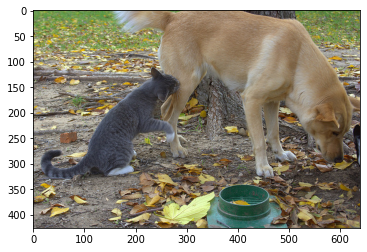

<start> a woman is putting food in a kitchen .


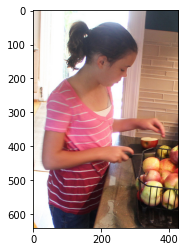

<start> a man standing next to a woman in a green field .


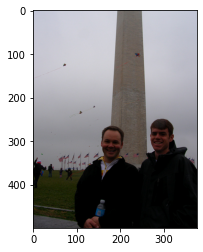

<start> a man is standing in front of a computer .


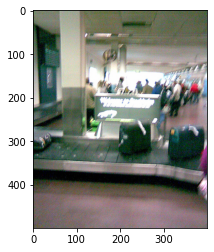

<start> a man riding a skateboard down a ramp .


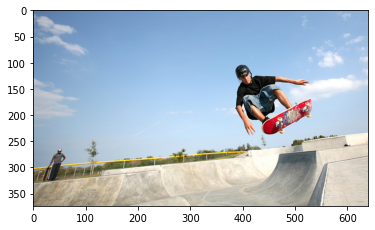

<start> a table with pizza on it sitting on a table .


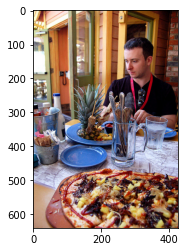

<start> a vase with a flower in it sitting on a table .


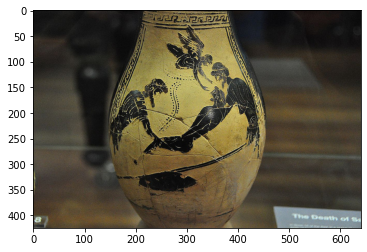

<start> a woman is sitting in a bathroom with a sink and a toilet .


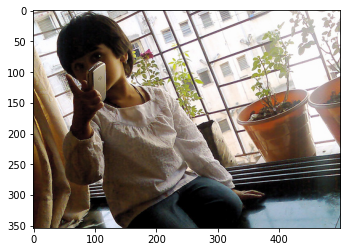

<start> a train traveling down tracks next to a tall building .


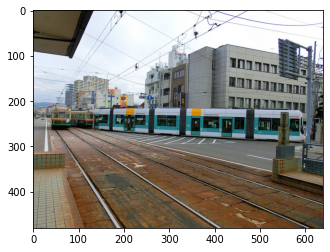

<start> a horse and rider on a horse in a field .


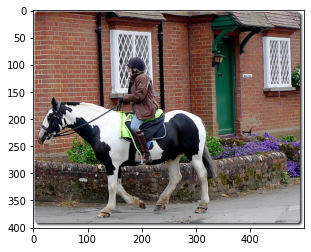

<start> a table with a plate of food on it


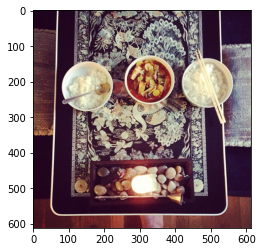

<start> a group of boats floating on top of a lake .


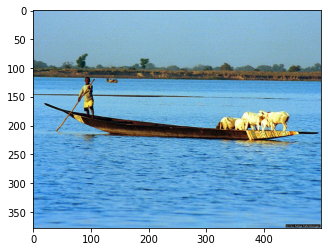

<start> a truck that is sitting in the grass .


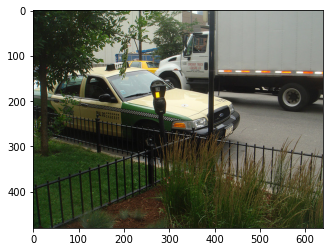

<start> a man riding a skateboard down a ramp .


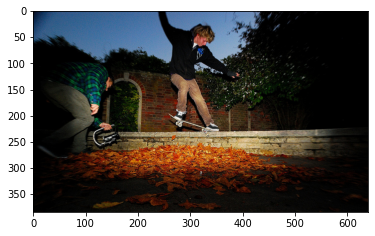

<start> a man is walking down a street with a briefcase .


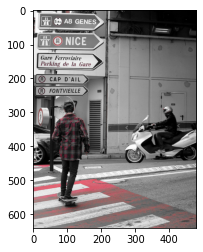

<start> a kitchen with a table and chairs with a microwave


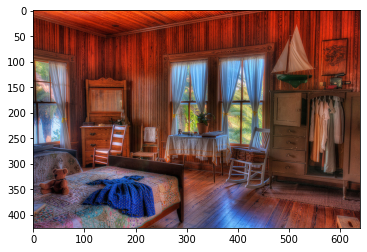

<start> a vase filled with flowers sitting on top of a table .


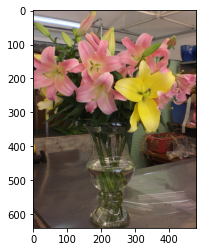

<start> a group of people on motor bikes on a street .


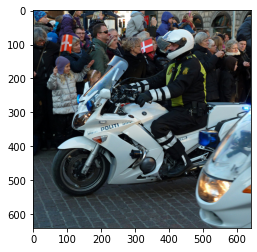

<start> a group of people sitting at a table with food .


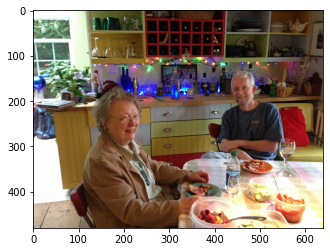

<start> a baseball player is swinging at a ball .


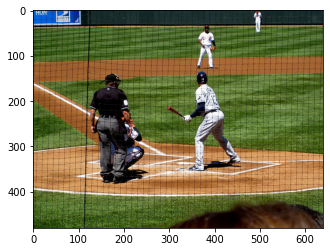

<start> a woman holding a pink umbrella while standing in a park .


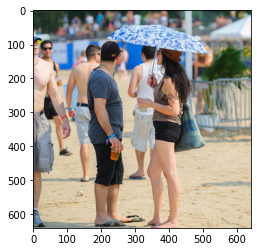

<start> a giraffe standing in a field with trees in the background


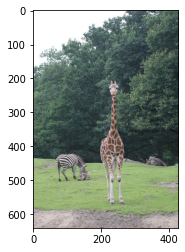

<start> a man holding a rainbow colored umbrella while standing on a beach .


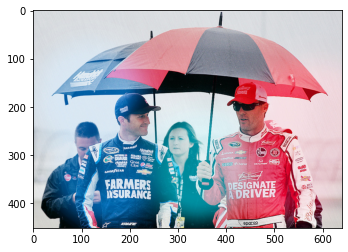

In [22]:
test_image_directory = '/content/test'
get_predictions(test_image_dir= test_image_directory)